# Audio Enginering Basics

## 1. Load Audio and inspect properties

In [1]:
from pydub import AudioSegment

audio = AudioSegment.from_file("Song.mp3")

In [2]:
print("Duration of the audio: ", len(audio))
print("Channels: ", audio.channels)
print("Sample width: ", audio.sample_width)
print("Frame rate: ", audio.frame_rate)
print("dbFS: ", audio.dBFS)

Duration of the audio:  276132
Channels:  2
Sample width:  2
Frame rate:  44100
dbFS:  -7.970869345064707


## 2. Slicing Audio 

In [3]:
first_5_seconds = audio[:5000]
next_5_seconds = audio[5000:10000]
last_5_seconds = audio[-5000:]

In [4]:
print("First 5 seconds: ", len(first_5_seconds))
print("Next 5 seconds: ", len(next_5_seconds))
print("Last 5 seconds: ", len(last_5_seconds))


First 5 seconds:  5000
Next 5 seconds:  5000
Last 5 seconds:  5000


## 3. Fade in and Fade Out

In [5]:
fade_in_chip = audio[:5000].fade_in(3000)
fade_out_chip = audio[:5000].fade_out(3000)

## 4. Concatenation Demo

In [6]:
Combine = fade_in_chip + fade_out_chip
print("Combined audio duration: ", len(Combine))

Combined audio duration:  10000


## 5. Waveform using librosa and matplotlib

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?


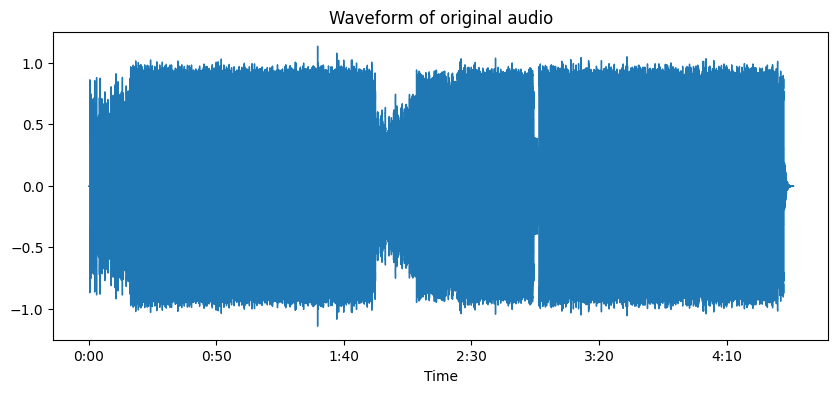

In [7]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

y, sr = librosa.load("Song.mp3", sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of original audio")
plt.show()

## 6. Visualize the Fade in and Fade out

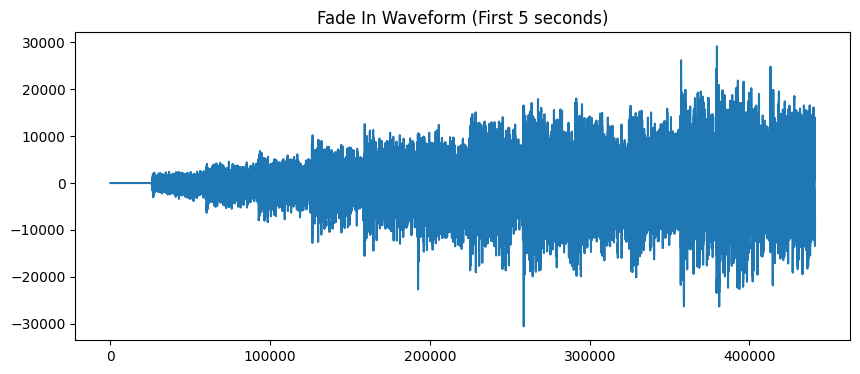

In [8]:
fade_in_audio = fade_in_chip.get_array_of_samples()
fade_out_audio = fade_out_chip.get_array_of_samples()

plt.figure(figsize=(10, 4))
plt.plot(fade_in_audio, label="Fade In")
plt.title("Fade In Waveform (First 5 seconds)")
plt.show()

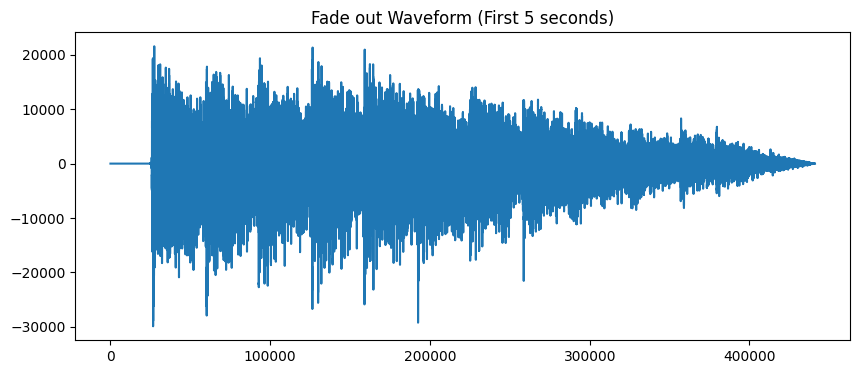

In [9]:

plt.figure(figsize=(10, 4))
plt.plot(fade_out_audio, label="Fade out")
plt.title("Fade out Waveform (First 5 seconds)")
plt.show()

## 7. Logic 

In [10]:
from pydub import AudioSegment
import os, random

In [11]:
def smooth_fade_mixtape(folder, output="output/smooth_fade_mixtape.mp3", transition_ms=6000):
    files = [f for f in os.listdir(folder) if f.endswith(('.mp3', '.wav'))]
    random.shuffle(files)

    mixtape = None
    for i, file in enumerate(files):
        song = AudioSegment.from_file(os.path.join(folder, file))
        song = song.set_channels(2).set_frame_rate(44100)

        if mixtape is None:
            mixtape = song
        else:
            overlap = min(transition_ms, len(song), len(mixtape))
            outro = mixtape[-overlap:].fade_out(overlap).low_pass_filter(4000)
            intro = song[:overlap].fade_in(overlap).low_pass_filter(4000)

            transition = outro.overlay(intro)
            mixtape = mixtape[:-overlap] + transition + song[overlap:]

    mixtape.export(output, format="mp3")
    print(f"Mixtape generated successfully: {output}")

smooth_fade_mixtape("Mixtape")

Mixtape generated successfully: output/smooth_fade_mixtape.mp3


In [14]:
import os
import re
from dataclasses import dataclass
from typing import List, Optional, Tuple

# Optional but recommended:
# pip install mutagen
try:
    from mutagen import File as MutagenFile
except ImportError:
    MutagenFile = None


AUDIO_EXTS = (".mp3", ".wav")


@dataclass
class TrackInfo:
    filename: str
    title: str
    artist: Optional[str]
    duration_s: int


def sanitize_filename_to_title(name: str) -> str:
    """Fallback: turn '01 - Artist - Track (Remix).mp3' -> 'Artist - Track (Remix)'."""
    base = os.path.splitext(os.path.basename(name))[0]
    base = re.sub(r"^\s*\d+\s*[-_. ]\s*", "", base)  # strip leading track number
    base = re.sub(r"\s+", " ", base).strip()
    return base


def format_timestamp(total_seconds: int) -> str:
    h = total_seconds // 3600
    m = (total_seconds % 3600) // 60
    s = total_seconds % 60
    return f"{h:d}:{m:02d}:{s:02d}" if h > 0 else f"{m:d}:{s:02d}"


def read_tags_and_duration(path: str) -> Tuple[str, Optional[str], int]:
    """
    Returns (title, artist, duration_s).
    Uses mutagen when available; otherwise falls back to filename and duration=0.
    """
    fallback_title = sanitize_filename_to_title(path)
    fallback_artist = None

    if MutagenFile is None:
        # No mutagen installed
        return fallback_title, fallback_artist, 0

    audio = MutagenFile(path, easy=True)
    if audio is None:
        return fallback_title, fallback_artist, 0

    # Duration
    duration_s = 0
    try:
        duration_s = int(audio.info.length)
    except Exception:
        duration_s = 0

    # Tags
    title = fallback_title
    artist = None
    try:
        if audio.tags:
            # Common EasyID3 keys: 'title', 'artist'
            t = audio.tags.get("title", [None])[0]
            a = audio.tags.get("artist", [None])[0]
            if t:
                title = str(t).strip()
            if a:
                artist = str(a).strip()
    except Exception:
        pass

    return title, artist, duration_s


def load_tracks_from_folder(folder: str, shuffle: bool = False) -> List[TrackInfo]:
    import random

    files = [
        f for f in os.listdir(folder)
        if f.lower().endswith(AUDIO_EXTS)
    ]
    files.sort()  # stable order by default
    if shuffle:
        random.shuffle(files)

    tracks: List[TrackInfo] = []
    for f in files:
        path = os.path.join(folder, f)
        title, artist, duration_s = read_tags_and_duration(path)
        tracks.append(TrackInfo(filename=f, title=title, artist=artist, duration_s=duration_s))

    return tracks


def build_tracklist_with_timestamps(
    tracks: List[TrackInfo],
    transition_ms: int = 6000,
) -> Tuple[str, int]:
    """Return (tracklist_text, total_duration_s) for the *final mixed audio*.

    Important: in a crossfaded mix, each transition overlaps audio, so the final
    mixtape length (and each next track's start time) is shorter than the simple
    sum of track durations.

    We approximate the overlap per transition as:
    overlap_s = min(transition_s, prev_track_duration, current_track_duration)

    Track i starts at the current mix cursor.
    Then the cursor advances by (current_duration - overlap_s).
    """

    lines: List[str] = []
    cursor_s: float = 0.0
    transition_s: float = max(0.0, transition_ms / 1000.0)

    prev_dur: Optional[int] = None
    for t in tracks:
        ts = format_timestamp(int(cursor_s))
        display = f"{t.artist} – {t.title}" if t.artist else t.title
        lines.append(f"{ts}  {display}")

        dur = max(0, int(t.duration_s))
        if prev_dur is None:
            cursor_s += dur
        else:
            overlap = min(transition_s, float(prev_dur), float(dur))
            cursor_s += max(0.0, float(dur) - overlap)

        prev_dur = dur

    return "\n".join(lines), int(cursor_s)


def generate_edm_hashtags(extra_tags: Optional[List[str]] = None, max_tags: int = 15) -> str:
    """
    YouTube handles hashtags best when not excessive.
    This returns a curated EDM set + optional extras.
    """
    base = [
        "#EDM", "#ElectronicMusic", "#DanceMusic", "#DJMix", "#Mix",
        "#HouseMusic", "#TechHouse", "#DeepHouse", "#ProgressiveHouse",
        "#Trance", "#Dubstep", "#DrumAndBass", "#FutureBass",
        "#Rave", "#Festival"
    ]
    if extra_tags:
        for t in extra_tags:
            t = t.strip()
            if not t:
                continue
            if not t.startswith("#"):
                t = "#" + re.sub(r"\s+", "", t)
            base.append(t)

    # Deduplicate while keeping order
    seen = set()
    uniq = []
    for t in base:
        if t.lower() not in seen:
            uniq.append(t)
            seen.add(t.lower())

    return " ".join(uniq[:max_tags])


def generate_youtube_description(
    folder: str,
    mixtape_title: str = "Smooth Fade EDM Mixtape",
    shuffle: bool = True,
    transition_ms: int = 6000,
    include_disclaimer: bool = True,
    extra_hashtags: Optional[List[str]] = None
) -> str:
    tracks = load_tracks_from_folder(folder, shuffle=shuffle)

    tracklist, total_s = build_tracklist_with_timestamps(tracks, transition_ms=transition_ms)
    total_len = format_timestamp(total_s)

    hashtags = generate_edm_hashtags(extra_tags=extra_hashtags)

    # A punchy but safe YouTube-style description
    intro = (
        f"{mixtape_title}\n\n"
        f"A seamless EDM listening session with smooth crossfades (~{transition_ms/1000:.1f}s) "
        f"built from my current rotation. Put this on for focus, driving, gym, or late-night vibes.\n\n"
        f"Total length: {total_len}\n"
    )

    tips = (
        "\n🧠 Tip: If you like a particular track, drop the timestamp in the comments and I’ll pin it.\n"
    )

    disclaimer = ""
    if include_disclaimer:
        disclaimer = (
            "\n\n⚠️ Disclaimer:\n"
            "Track credits belong to their respective owners. If you’re a rights holder and want changes, "
            "reach out and I’ll respond quickly.\n"
        )

    description = (
        intro
        + "\n🎵 Tracklist:\n"
        + tracklist
        + tips
        + disclaimer
        + "\n\n"
        + hashtags
    )

    return description


if __name__ == "__main__":
    # Example usage:
    folder = "Mixtape"  # same folder you used in smooth_fade_mixtape("Mixtape")
    desc = generate_youtube_description(
        folder=folder,
        mixtape_title="Smooth Fade EDM Mixtape | Seamless Transitions",
        shuffle=True,              # set False if you want alphabetical / stable order
        transition_ms=6000,
        include_disclaimer=True,
        extra_hashtags=["Techno", "MelodicHouse"]  # optional
    )
    print(desc)


Smooth Fade EDM Mixtape | Seamless Transitions

A seamless EDM listening session with smooth crossfades (~6.0s) built from my current rotation. Put this on for focus, driving, gym, or late-night vibes.

Total length: 0:00

🎵 Tracklist:
0:00  Song
0:00  Diomi ft Gocat - Final Outpost
🧠 Tip: If you like a particular track, drop the timestamp in the comments and I’ll pin it.


⚠️ Disclaimer:
Track credits belong to their respective owners. If you’re a rights holder and want changes, reach out and I’ll respond quickly.


#EDM #ElectronicMusic #DanceMusic #DJMix #Mix #HouseMusic #TechHouse #DeepHouse #ProgressiveHouse #Trance #Dubstep #DrumAndBass #FutureBass #Rave #Festival


In [ ]:
import subprocess
import os
from PIL import Image

In [ ]:
def make_video_from_audio_optimized(image_path, audio_path, output_path="output/mixtape_video1.mp4",video_resolution=(1280,720), fps=1, preset="ultrafast"):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    img_resized_path = "temp_resized_image.jpg"
    img = Image.open(image_path)
    img = img.resize(video_resolution)
    img.save(img_resized_path)

    cmd = [
        "ffmpeg", # invoke ffmpeg program
        "-y", # overwrite output file if it exists
        "-loop", "1", # loop the image so it stays on screen
        "-i", img_resized_path, # input #1 image to loop
        "-i", audio_path, # input #2 audio file to use
        "-c:v", "libx264", # video codec 
        "-preset", preset, # use preset for faster encoding
        "-tune", "stillimage", # optimize for still images
        "-r", str(fps), # frames per second
        "-c:a", "aac", # audio codec
        "-b:a", "192k", # audio bitrate
        "-shortest", # force the shortest duration
        output_path, # output file       
    ]

    try:
        subprocess.run(cmd,check=True)
        print(f"Video created: {output_path}")
    except subprocess.CalledProcessError as e:
        print("FFMPEG process failed",e)
    finally:
        if os.path.exists(img_resized_path):
            os.remove(img_resized_path)

